<a href="https://colab.research.google.com/github/catalinapesquet/PINNS-Code-and-Notes/blob/main/PINNS_BurgersEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Libraries**

In [132]:
import torch
import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io

# Auxiliary Functions

In [133]:
def plot3D(x, t, y):
    # Ensure x and t are PyTorch tensors
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if isinstance(t, np.ndarray):
        t = torch.from_numpy(t)

    # Squeeze tensors to remove extra dimensions
    x_plot = x.squeeze(-1)  # Squeeze the last dimension if necessary
    t_plot = t.squeeze(-1)

    # Create a meshgrid using PyTorch with swapped axes
    X, T = torch.meshgrid(t_plot, x_plot, indexing='ij')  # Swapped order of t_plot and x_plot

    # Ensure y is also a tensor and convert to numpy for plotting
    F_xt = y
    if isinstance(F_xt, torch.Tensor):
        F_xt = F_xt.numpy()

    # Plot the 2D Contour
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(X.numpy(), T.numpy(), F_xt.T, 20, cmap="rainbow")  # Note: transpose F_xt
    fig.colorbar(cp)
    ax.set_title('F(x,t)')
    ax.set_xlabel('x')  # Swapped labels
    ax.set_ylabel('t')
    plt.show()

    # Plot the 3D Surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), T.numpy(), F_xt.T, cmap="rainbow")  # Note: transpose F_xt
    ax.set_xlabel('x')  # Swapped labels
    ax.set_ylabel('t')
    ax.set_zlabel('f(x,t)')
    plt.show()


In [134]:
def plot3D_Matrix(x, t, y):
    # Ensure shapes and types match
    X, T = x, t
    F_xt = y

    # Debug shapes
    print("X shape:", X.shape)
    print("T shape:", T.shape)
    print("F_xt shape:", F_xt.shape)

    # Convert tensors to NumPy arrays if needed
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    if isinstance(T, torch.Tensor):
        T = T.numpy()
    if isinstance(F_xt, torch.Tensor):
        F_xt = F_xt.numpy()

    # Ensure X, T, and F_xt have the same shape
    assert X.shape == T.shape == F_xt.shape, "Input shapes do not match!"

    # Plot the 2D contour
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(T, X, F_xt, 20, cmap="rainbow")  # Note: T and X order is swapped
    fig.colorbar(cp)  # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

    # Plot the 3D surface
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt, cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()


In [135]:
print("arr_x1:", arr_x1.shape)
print("arr_T1:", arr_T1.shape)
print("torch.from_numpy(u_pred):", torch.from_numpy(u_pred).shape)


arr_x1: torch.Size([256, 100])
arr_T1: torch.Size([256, 100])
torch.from_numpy(u_pred): torch.Size([256, 100])


In [136]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                extent=[T.min(), T.max(), X.min(), X.max()],
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 0.5, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)

    '''
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.75s$', fontsize = 10)

    plt.savefig('Burgers-Inverse.png',dpi = 500)

# **PINNS for Inverse Problems or "Data driven Discovery of Nonlinear Partial Differential Equations"**

For parameterized and nonlinear partial differential equations of the general form:
$ u_t + N[u;\lambda]= 0 $

where, $u(x,t)$ is the hidden solution and $N[;\lambda]$ is a nonlinear operator parameterized by $\lambda$.


In short: we will use a PINN to get $\lambda$.


Inverse Problem: Data -> Model's paramters so:
Data -> PINN -> Model's parameters (i.e. our PDE parameters).



## Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)


## **Problem Setup**

**Burgers' Equation**

Burgers' equation is a fundamental partial differential equation (PDE) that arises in various areas of applied mathematics, including fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. In the mechanic field it would be related to the dynamic viscosity.

$$\frac{\partial u}{\partial t}+ \lambda_1u\frac{\partial u}{\partial x}=\lambda_2\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

## Analysis:







Let:

$u_t = \frac{\partial u}{\partial t}$

$u_x = \frac{\partial u}{\partial x}$

$u_{xx} = \frac{\partial^2 u}{\partial x^2}$

$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$

Our PDE is described as:

$$u_t+\lambda_1uu_x=\lambda_2u_{xx}$$

Or,

$$u_t+\mathscr{N}[u;\lambda]=0$$

So we can use a PINN to obtain $\lambda$.

In our case (from the reference solution) $\lambda=[\lambda_1,\lambda_2]=[1,\nu]=\left[1,\frac{1}{100\pi}\right]$

Since N(x,t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(t,x)\approx u(t,x)$$

Then:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx u_t+uu_x-\lambda u_{xx}=0$$

And:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx 0$$


We define this function as $f$:

$$f(t,x)=N_t+\lambda_1NN_x-\lambda_2N_{xx}$$

Remember our operator:

$$f(t,x)=N_t+\mathscr{N}[N,\lambda]$$

So:

$$f(t,x)\approx 0$$


## Loss function

We evaluate $f$ in a certain number of points ($N_u$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_u}\sum^{N_u}_{i=1}|f(t_u^i,x_u^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **As this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_u$** (compare it to the reference solution).

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|u(t_{u}^i,x_u^i)-N(t_{u}^i,x_u^i)|^2$$

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the ODE parameters (i.e., $\lambda$)→ We will ask our neural network to find our $\lambda$.

# **Data**

In [137]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [138]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

In [139]:
data = scipy.io.loadmat('/content/gdrive/MyDrive/Burgers.mat')

In [140]:
# Let's see the labels
data

# x: spacial domain, usol: real solution, t: temporal domain

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 30 11:20:07 2020',
 '__version__': '1.0',
 '__globals__': [],
 't': array([[0.  ],
        [0.01],
        [0.02],
        [0.03],
        [0.04],
        [0.05],
        [0.06],
        [0.07],
        [0.08],
        [0.09],
        [0.1 ],
        [0.11],
        [0.12],
        [0.13],
        [0.14],
        [0.15],
        [0.16],
        [0.17],
        [0.18],
        [0.19],
        [0.2 ],
        [0.21],
        [0.22],
        [0.23],
        [0.24],
        [0.25],
        [0.26],
        [0.27],
        [0.28],
        [0.29],
        [0.3 ],
        [0.31],
        [0.32],
        [0.33],
        [0.34],
        [0.35],
        [0.36],
        [0.37],
        [0.38],
        [0.39],
        [0.4 ],
        [0.41],
        [0.42],
        [0.43],
        [0.44],
        [0.45],
        [0.46],
        [0.47],
        [0.48],
        [0.49],
        [0.5 ],
        [0.51],
        [0.52],
        

In [141]:
x = data['x']
t = data['t']
usol = data['usol']

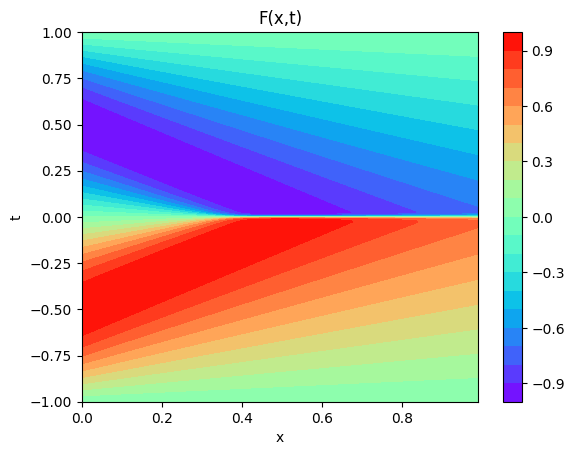

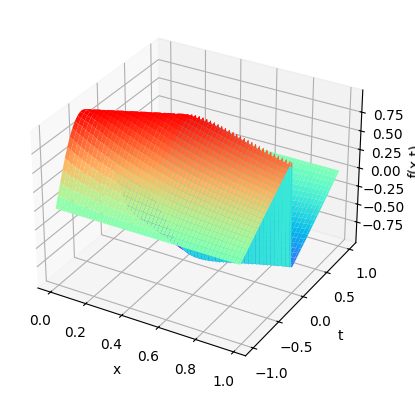

In [142]:
plot3D(x, t, usol)

## Prepare the data

In [143]:
print(x.shape, t.shape)

(256, 1) (100, 1)


In [144]:
X, T = np.meshgrid(x,t)
X.shape, T.shape

((100, 256), (100, 256))

In [145]:
# We need to vectorize our input and output variables
X_true = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
U_true = usol.flatten('F')[:,None]
X_true.shape

(25600, 2)

In [146]:
# lower bound
lb = X_true[0]

# upper bound
ub = X_true[-1]

lb, ub

(array([-1.,  0.]), array([1.  , 0.99]))

## Training data

In [147]:
# how many points we have
total_points = len(x)*len(t)
total_points

25600

In [148]:
N_u = 1000
idx = np.random.choice(total_points, N_u, replace=False)

In [149]:
# Array that contains those random points
X_train_Nu = X_true[idx]
U_train_Nu = U_true[idx]

In [150]:
# Send all arrays to device
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
U_true = torch.from_numpy(U_true).float().to(device)

## Initialize our parameters

Our operator is:

$$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$$

We know that:

$$\lambda_1=1$$

$$\lambda_2=\nu=\frac{1}{100\pi}=0.003183$$

In [151]:
lambda1=2.0
lambda2=0.02
nu = 0.01/np.pi #diffusion coefficient

print("Te real 𝜆 = [", 1.0,nu,"]. Our initial guess will be 𝜆 _PINN= [",lambda1,lambda2,"]")

Te real 𝜆 = [ 1.0 0.003183098861837907 ]. Our initial guess will be 𝜆 _PINN= [ 2.0 0.02 ]


# **Neural Network**



In [152]:
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class

        'activation function'
        self.activation = nn.Tanh()

        'Initialize neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):

            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling

        #convert to float
        a = x.float()

        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        a = self.linears[-1](a)

        return a

In [153]:
f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

In [154]:
class FCN():
  def __init__(self, layers):
    # initialize parameters
    self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)
    self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)

    # Register lambda to optimize
    self.lambda1 = nn.Parameter(self.lambda1)
    self.lambda2 = nn.Parameter(self.lambda2)

    # Call our DNN
    self.dnn = DNN(layers).to(device)
    self.dnn.register_parameter('lambda1', self.lambda1)
    self.dnn.register_parameter('lambda2', self.lambda2)

    # Loss function (Mean squared error)
    self.loss_function = nn.MSELoss(reduction='mean')

    self.iter = 0

  def loss_data(self, x, u):
    loss_u = self.loss_function(self.dnn(x), u)
    return loss_u

  def loss_PDE(self, X_train_Nu): # partial differential equation
    # f parameterized by lambda, start by initializing lambda
    lambda1 = self.lambda1
    lambda2 = self.lambda2

    g = X_train_Nu.clone() # contains all x and t
    g.requires_grad = True

    # evaluate deep neural network
    u = self.dnn(g)

    # we need first derivative respect to t and first and second derivative respect to x
    u_x_t = autograd.grad(u, g, torch.ones([X_train_Nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
    u_xx_tt = autograd.grad(u_x_t, g, torch.ones(X_train_Nu.shape).to(device), create_graph=True)[0]
    u_x = u_x_t[:, [0]]
    u_t = u_x_t[:, [1]]
    u_xx = u_xx_tt[:, [0]]

    f = u_t + (lambda1)*(self.dnn(g))*(u_x) - (lambda2)*u_xx

    # f should be close to zero
    loss_f = self.loss_function(f, f_hat)
    return loss_f

  def loss(self, x, y):
    loss_u = self.loss_data(x,y)
    loss_f = self.loss_PDE(x)
    loss_val = loss_u + loss_f
    return loss_val

  # callable for optimization
  def closure(self):
    optimizer.zero_grad()
    loss = self.loss(X_train_Nu, U_train_Nu)
    loss.backward()

    self.iter += 1
    if self.iter % 100 == 0:
            error_vec, _ = PINN.test()
            print(
                'Relative Error(Test): %.5f , 𝜆_real = [1.0,  %.5f], 𝜆_PINN = [%.5f,  %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    nu,
                    self.lambda1.item(),
                    self.lambda2.item()
                )
            )
    return loss

    # evaluate our neural network
  def test(self):
    u_pred = self.dnn(X_true)
    error_vec = torch.linalg.norm(U_true-u_pred, 2)/torch.linalg.norm(U_true, 2)
    u_pred = u_pred.cpu().detach().numpy()
    u_pred = np.reshape(u_pred, (x.shape[0], t.shape[0]), order='F')
    return error_vec, u_pred


## Trainning the NN

In [155]:
# 8 hidden layers
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [156]:
PINN = FCN(layers)
PINN

In [157]:
params = list(PINN.dnn.parameters())

Here we use L-BFGS optimizer.

https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html

In [158]:
optimizer = torch.optim.LBFGS(params,
                              lr = 1e-1,
                              max_iter = 20000,
                              max_eval = None,
                              tolerance_grad = 1e-11,
                              tolerance_change = 1e-11,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')

In [159]:
optimizer.step(PINN.closure)

Relative Error(Test): 0.44883 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.83095,  0.01224]
Relative Error(Test): 0.28770 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.05067,  0.00089]
Relative Error(Test): 0.26266 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.06539,  0.00055]
Relative Error(Test): 0.24395 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.19975,  0.00239]
Relative Error(Test): 0.20781 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.46429,  0.00601]
Relative Error(Test): 0.19428 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.54954,  0.00779]
Relative Error(Test): 0.16869 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.65641,  0.00864]
Relative Error(Test): 0.15278 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.67664,  0.00701]
Relative Error(Test): 0.13614 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.69093,  0.00721]
Relative Error(Test): 0.11930 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.74079,  0.00747]
Relative Error(Test): 0.10829 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.80025,  0.00802]
Relative Error(Test): 0.09315 , 𝜆_real = [1

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)

Our Physics Informmed Neural Network did a good job estimating our parameters (0.989 / 1 for lambda1 and 0.0034 / 0.00318 for lambda2).

# **Plots**

Plot of our solution:

Black dots = Training points (inside our domain as we are in an inverse problem here).

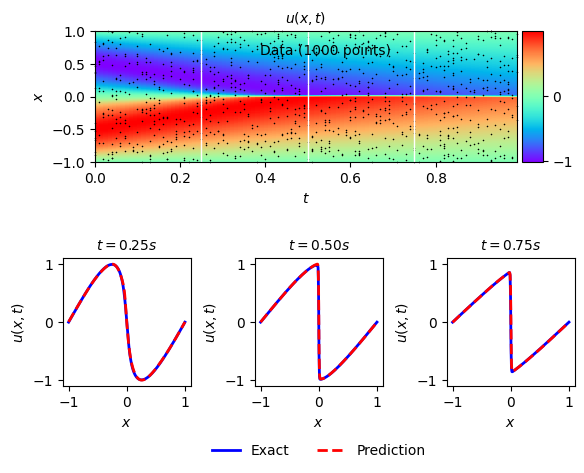

In [160]:
error_vec, u_pred = PINN.test()
solutionplot(u_pred, X_train_Nu.cpu().detach().numpy(), U_train_Nu)

In [161]:
x1=X_true[:,0]
t1=X_true[:,1]

In [162]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

Final Plot:

The plot we predicted with our model. Very close to the real solution.

X shape: torch.Size([256, 100])
T shape: torch.Size([256, 100])
F_xt shape: torch.Size([256, 100])


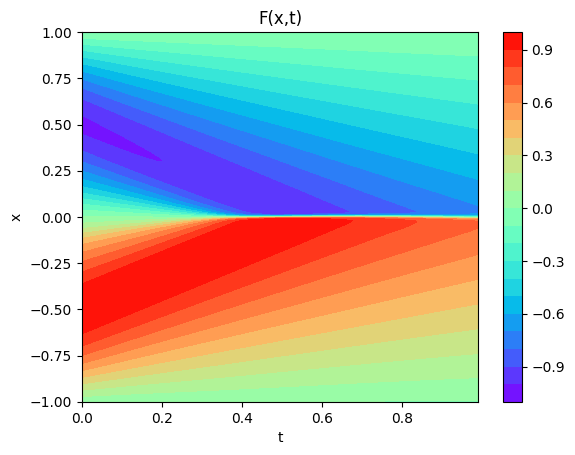

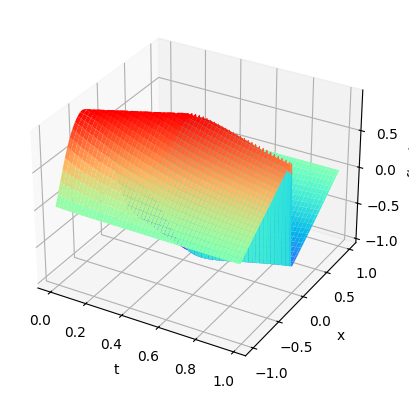

In [163]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(u_pred))

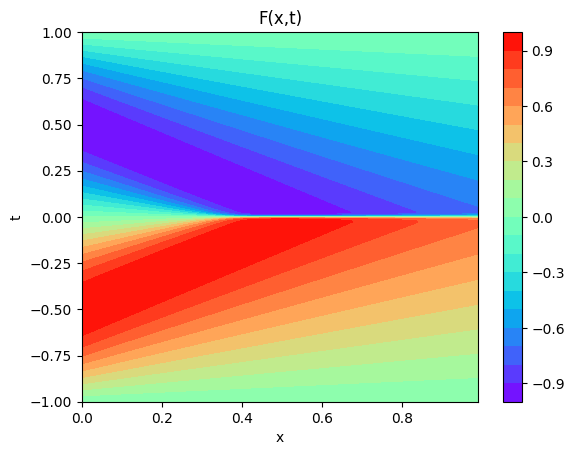

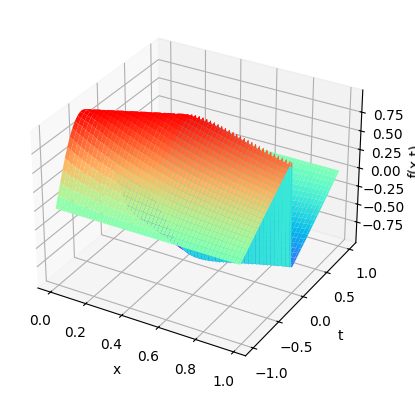

In [164]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))